In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
#from varname import nameof

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Create dataset for regression analysis

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df.columns

Index(['the_combined_slp', 'the_combined_rlm', 'bdew [TWh]',
       'gas_to_electricity', 'electricity_from_gas', 'gas_price [€/MWh]',
       'scaled_space_private', 'scaled_space_tertiary', 'scaled_decentral_chp',
       'scaled_space_industry', 'scaled_district_heat',
       'aggregated(incl_small_chp)', 'index', 'time', 'year', 'month',
       'weekday', 'weekday_num', 'monday', 'friday', 'weekend',
       'christmas_period', 'holiday', 'bridgeday'],
      dtype='object')

In [5]:
df = df[df.index.duplicated()==False]

In [6]:
df["time"] = range(len(df))

In [7]:
solar = pd.read_csv(os.path.join(data_path, "solar.csv"), index_col=0)
solar.index = pd.DatetimeIndex(solar.index)
solar = solar.resample("D").mean()
solar.loc[(solar.index >= df.index[0]) & (solar.index <= df.index[-1])]
solar[solar.index.duplicated()==False]

solar = solar * 2.77778e-7
solar = solar.rename(columns={"solar [J/m^2]" : "solar [kWh/m^2]"})

In [8]:
temperature = pd.read_csv(os.path.join(data_path, "aggregated_temperature.csv"), index_col=0)
temperature.index = pd.DatetimeIndex(temperature.index)
temperature = temperature.resample("D").mean()
temperature = temperature.loc[df.index[0]:df.index[-1]]
temperature[temperature.index.duplicated()==False]

ref_temperature = pd.read_csv(os.path.join(data_path, "aggregated_reference_temperature.csv"), index_col=0)
ref_temperature.index = pd.DatetimeIndex(ref_temperature.index)
ref_temperature = ref_temperature.resample("D").mean()
ref_temperature = ref_temperature.loc[df.index[0]:df.index[-1]]

In [9]:
producing_sector = pd.read_csv(os.path.join(data_path, "manufacturing.csv"), index_col=0, sep=";", dtype={"Kalender- und saisonbereinigt nach X13 JDemetra+":np.float64}, decimal=",")
producing_sector = producing_sector.iloc[:,0] #0: original, 1: adjusted values

producing_sector.index = pd.DatetimeIndex(producing_sector.index)
producing_sector.resample("D").sum()
producing_sector = producing_sector.reindex(df.index, method = "nearest")
producing_sector = producing_sector.loc[df.index[0]:df.index[-1]]
producing_sector.index = df.index 

df["producing_sector"] = producing_sector

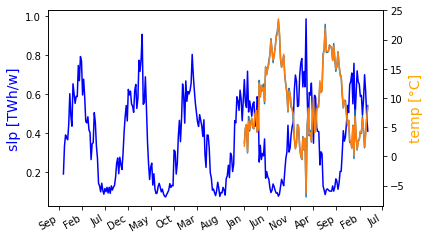

In [10]:
fig,ax = plt.subplots()

ax.plot(df["scaled_space_private"].resample("w").mean(), color="blue")
ax.set_ylabel("slp [TWh/w]",  color="blue", fontsize=14)

ax2=ax.twinx()
ax2.plot(pd.concat([temperature, ref_temperature], axis=1).resample("w").mean())
ax2.set_ylabel("temp [°C]", color="orange", fontsize=14)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.show()

temperature.index = df.index
ref_temperature.index = df.index

df["temperature"] = temperature
df["ref_temperature"] = ref_temperature

# Disaggregation based on fundamental assumption / energy balances

C:\Users\C3250~1.STI\AppData\Local\Temp/ipykernel_23372/1742512260.py:14: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.fill_between(dft.index, upper-sector, upper, color="tab:orange", hatch=h, edgecolor="k", alpha=0.5, label=label)


ConversionError: Failed to convert value(s) to axis units: '2022-01-01'

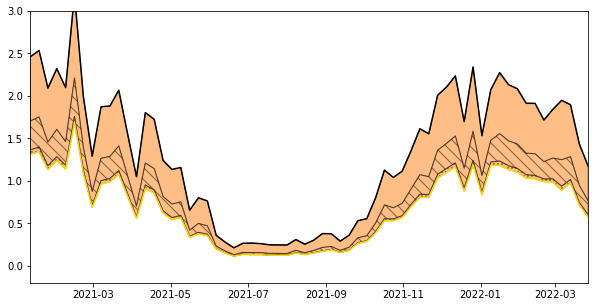

In [12]:
#weekly
plt.figure(figsize=(10,5))
dft = df.resample("1w").mean().dropna()
plt.xlim(dft.index[[0, -1]])

#scaling factors from AGEBL
private = dft["scaled_space_private"] 
tertiary = dft["scaled_space_tertiary"]
decentral_chp = dft["scaled_decentral_chp"]

upper=dft['the_combined_slp']
plt.plot(dft.index, dft['the_combined_slp'], label='THE SLP', color="k")
for sector,h,label in [(private, " ", "private"), (tertiary,  "\\\\", "tertiary"), (decentral_chp, "...", "decentral_chp")]:
    plt.fill_between(dft.index, upper-sector, upper, color="tab:orange", hatch=h, edgecolor="k", alpha=0.5, label=label)
    upper = upper - sector 

plt.plot(upper.index, upper, color="gold", label="residual_SLP")



plt.ylim(-0.2, 3)
plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

In [ ]:
plt.figure(figsize=(10,5))

dft= df.resample("1w").mean()
the_rlm = dft['the_combined_rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - dft['gas_to_electricity']
industry = dft["scaled_space_industry"]

upper=the_rlm
for sector, c, label in [(industry,"tab:red","scaled_space_industry"), (dft["scaled_district_heat"], "tab:orange", "dist_heat"), (dft['gas_to_electricity'],  "tab:green", "power sector")]:
    plt.fill_between(dft.index, upper-sector, upper , color="{}".format(c), alpha=0.3, label=label)
    upper = upper-sector 
upper.plot(color="gold", label="residual_RLM")

plt.xlim(power_res.dropna().index[[0, -1]])
plt.ylim(0, 3)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

plt.show()

# Estimations: X^= a + b*X

In [13]:
df_x = df
#df_x["power"]=df["electricity_from_gas"]**2
#df_x["power"]=df["electricity_from_gas"]**2
df_x["solar"] = solar
#df_x["temperature"] = temperature
df_x = df_x.rename(columns = {
    "aggregated(incl_small_chp)" : "slp_w2h",
    "dist_heat": "slp_w2h_dh",
    "the_combined_slp" : "slp_the",
    "the_combined_rlm" : "rlm_the",
    "bdew [TWh]" : "bdew",
    "gas_price [€/MWh]" : "prices"
})

In [14]:
df_x["the_sum"] = df_x["rlm_the"] + df_x["slp_the"]

In [15]:
df_x_no_holiday = df_x[(df_x.holiday==0) & (df_x.christmas_period==0) & (df_x.bridgeday==0)]

## Fit model to 2021 and predict for 2022

In [16]:
df_x_no_holiday_2022 = df_x_no_holiday.loc[df_x_no_holiday.index.year == 2022]

In [17]:
df_x_no_holiday_2021 = df_x_no_holiday.loc[df_x_no_holiday.index.year == 2021]

In [18]:
#df_x_no_holiday = df_x_no_holiday.drop(columns="index")

## Augmented Dickey-Fuller test for stationarity

In [19]:
adfuller(df_x_no_holiday['rlm_the'].dropna(), regression='nc')

# p = 0.04910444772233917 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

(-0.6441809048960946,
 0.43610220609800693,
 18,
 1887,
 {'1%': -2.566925862267392,
  '5%': -1.9411432827160735,
  '10%': -1.6166800059028144},
 -1862.656769462828)

In [20]:
adfuller(df_x_no_holiday['slp_w2h'].dropna(), regression='c')

# we can only reject at 10% confidence level but this might change if bug in 2022 data is fixed

(-2.781476461924686,
 0.06096882701487613,
 12,
 1828,
 {'1%': -3.4339323339630248,
  '5%': -2.863122400533316,
  '10%': -2.5676124161116403},
 -4565.756874341419)

In [21]:
adfuller(df_x_no_holiday['electricity_from_gas'].dropna(), regression='c')

# p = 0.0011084722880644524 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

(-3.9322915831232477,
 0.001809641740138011,
 19,
 1849,
 {'1%': -3.433891590943719,
  '5%': -2.8631044140606456,
  '10%': -2.5676028389397336},
 -5013.961835778982)

In [22]:
adfuller(df_x_no_holiday['producing_sector'].dropna(), regression='c')

# p = 6.344246220602208e-05 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

(-4.805031697170629,
 5.3193289854920126e-05,
 0,
 1907,
 {'1%': -3.4337837305451755,
  '5%': -2.863056796670872,
  '10%': -2.5675774845276518},
 7390.720922023409)

## KPSS test for stationarity

In [23]:
kpss(df_x_no_holiday['rlm_the'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

C:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.08392521917294721,
 0.1,
 26,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [24]:
kpss(df_x_no_holiday['slp_w2h'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

C:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.28387538999617906,
 0.1,
 25,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [25]:
kpss(df_x_no_holiday['electricity_from_gas'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

C:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.25192873193079174,
 0.1,
 25,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [26]:
kpss(df_x_no_holiday['producing_sector'].dropna(), regression='c')

# p is very large -> we have to reject the null that the the process is (level) stationary
# CHECK: this is counterintuitive as the DF test finds the opposite

C:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.371043473817611,
 0.01,
 26,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## THE_RLM

In [27]:
high_gas_date = "2021-09-01"
covid_beginning = "2020-02-01"
invasion_date = "2022-02-24"
limiting_date = "2022-03-31"
df_x_no_holiday = df_x_no_holiday.loc[:limiting_date]

### Fitting period variation

In [28]:
#2020/09-2021/08 (before high gas prices)
model_the_20_09 = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_20_09 = model_the_20_09.fit() 

model_the_16_10 = smf.ols('rlm_the ~ 1 + slp_the + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_16_10 = model_the_16_10.fit() 

result_list = [
    (results_the_20_09,"fitting period: 2020/09 - 2021/08", '2020-09-01', high_gas_date),
    (results_the_16_10,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)
]


In [29]:
#results_the_20_09.summary()
#results_the_16_10.summary()

In [30]:
model_the_all = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')])
results_the_all = model_the_all.fit() 

#slp_the instead of slp_w2h included here - I think this caused the weird result
model_the_no_econ = smf.ols('rlm_the ~ 1 + slp_the + electricity_from_gas + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')])
results_the_no_econ = model_the_no_econ.fit() 

model_the_only_slp = smf.ols('rlm_the ~ 1 + slp_w2h + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')])
results_the_only_slp = model_the_only_slp.fit() 

result_list_2016 = [
    (results_the_only_slp, "only_slp"),
    (results_the_no_econ, "no_econ"),
    (results_the_all,"all")
]

### Controlvariable variation

In [31]:
#2020/09-2021/08 (before high gas prices)
result_list_2016 = []
for model_name in ["only_slp", "no_econ", "all"]:
    
    model = smf.ols(
        'rlm_the ~ 1 + slp_w2h + C(weekday)' 
        + ('+ electricity_from_gas' if model_name != 'only_slp' else '')
        + ('+ producing_sector' if model_name == 'all' else '')
        , data=df_x_no_holiday.loc[
        (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')]
    )
    results = model.fit() 

    result_list_2016.append((results, model_name))

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rlm_the   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1384.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):          1.82e-235
Time:                        10:13:48   Log-Likelihood:                 407.07
No. Observations:                 305   AIC:                            -794.1
Df Residuals:                     295   BIC:                            -756.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.6927      0.054     12.837      0.000       0.587       0.799
C(weekday)[T.Monday]        0.0468      0.014      3.382      0.001       0.020       0.074
C(weekday)[T.Saturday]     -0.1631      0.014    -11.361      0.000      -0.191      -0.135
C(weekday)[T.Sunday]       -0.1399      0.015     -9.355      0.000      -0.169      -0.110
C(weekday)[T.Thursday]      0.0572      0.014      4.011      0.000       0.029       0.085
C(weekday)[T.Tuesday]       0.0491      0.014      3.556      0.000       0.022       0.076
C(weekday)[T.Wednesday]     0.0518      0.014      3.746      0.000       0.025       0.079
slp_w2h                     0.7122      0.013     55.714      0.000       0.687       0.737
electricity_from_gas        1.0566      0.052     20.165      0.000       0.954       1.160
producing_sector            0.0027      0.001      5.125      0.000       0.002       0.004
==============================================================================
Omnibus:                        6.975   Durbin-Watson:                   0.558
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                8.540
Skew:                           0.206   Prob(JB):                       0.0140
Kurtosis:                       3.708   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

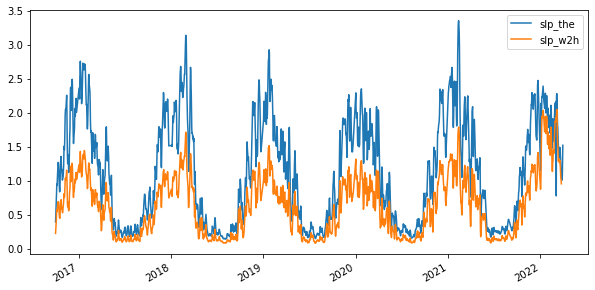

In [33]:
df_x_no_holiday.plot(y=['slp_the','slp_w2h'], figsize=(10,5))

In [34]:
def prediction(df, name, start_pred, end_pred, rlm=True):
    delta = pd.DataFrame()
    key_list = ["reported"]

    if rlm == True:
        rlm_slp = "rlm_the"
    else: 
        rlm_slp = "slp_the"
        
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_pred])
    
    df_pred.name = f"{name}_forecast"

    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_pred][rlm_slp]
    ], axis=1, keys=[name, "reported"])
    print(combined.loc[(combined.index <=end_pred) & (combined.index >=start_pred)].mean())
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    delta = pd.concat([delta, ts], axis=1)
    
    return combined, delta, key_list

In [35]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

energy_amounts = {
    "phase0" : df_x_no_holiday.loc[df_x_no_holiday.index<=high_gas_date]["rlm_the"],
    "phase1" : df_x_no_holiday.loc[
        (df_x_no_holiday.index>high_gas_date) &
        (df_x_no_holiday.index<=invasion_date)
                                  ]["rlm_the"],
    "phase2" : df_x_no_holiday.loc[df_x_no_holiday.index>invasion_date]["rlm_the"]
}

In [36]:
start_pred = high_gas_date
end_pred = limiting_date

for df, name in result_list_2016:
    
    combined, delta, key_list = prediction(df, name, start_pred, end_pred)
    
    result_dict[name]["phase0"] = (
        delta[name][delta[name].index <= high_gas_date].sum() / 
                                   energy_amounts["phase0"].sum()
                                  )
    result_dict[name]["phase1"] = delta[name][
        (delta[name].index > high_gas_date) & 
        (delta[name].index <=invasion_date)
    ].sum() / energy_amounts["phase1"].sum()
    result_dict[name]["phase2"] = delta[name][delta[name].index > invasion_date].sum() / energy_amounts["phase2"].sum()

only_slp    2.056453
reported    1.719066
dtype: float64
no_econ     1.909217
reported    1.719066
dtype: float64
all         1.919599
reported    1.719066
dtype: float64


In [37]:
(pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100)

,only_slp,no_econ,all
phase0,-0.001636,-0.001497,-0.001590
phase1,-15.098489,-8.044556,-8.374251
phase2,-35.104504,-21.207483,-22.917477


Text(0, 0.5, 'estimated reduction [%]')

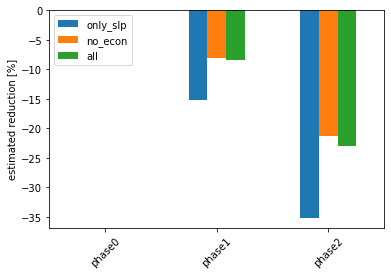

In [38]:
ax = (pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100).plot(kind = "bar", rot=45)
ax.set_ylabel("estimated reduction [%]")

In [39]:
result_list = [(results_the_no_econ,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)]
#(, "no_econ"),

fitting period: 2016/10 - 2021/08    1.617198
reported                             1.611420
dtype: float64


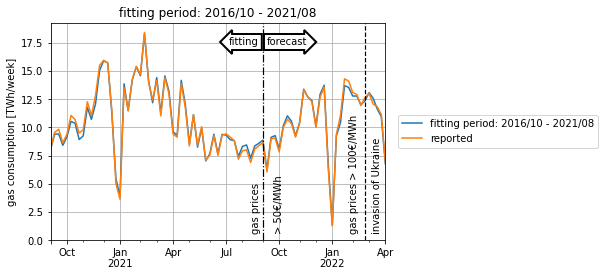

In [40]:
for df, name, start_pred, end_pred in result_list:
    
    combined, delta, key_list = prediction(df, name, start_pred, end_pred)
    
    ax =combined.loc["2020-09-01":].resample("1w").sum().plot(ylim=0, xlim=("2020-09-01",limiting_date), title = name)
    ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
    ax.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )
    
    ax.text((pd.to_datetime(high_gas_date)-pd.Timedelta(18, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices" +"\n"+"\n" + "> 50€/MWh", size=10, rotation=90)
    ax.text((pd.to_datetime(invasion_date)-pd.Timedelta(30, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices > 100€/MWh" + "\n" +"\n" + "invasion of Ukraine", size=10, rotation=90)
    
    fit = ax.text(
        (pd.to_datetime(high_gas_date)-pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 18, "fitting", ha="right", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
    forecast = ax.text(
        (pd.to_datetime(high_gas_date)+pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 18, "forecast", ha="left", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))
    
    plt.grid()
    ax.set_ylabel("gas consumption [TWh/week]")
    ax.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
    
    plt.show()
    
    key_list.append(name)
    

In [41]:
delta.index = combined.index
delta_rlm = delta.dropna()

Q1_delta_rlm = delta_rlm["2022-02-24":].sum(0)

percent = Q1_delta_rlm / combined.loc["2022-02-24":,"reported"].sum(0)*100

weekly_rlm = Q1_delta_rlm / len(delta_rlm["2022-02-24":].index) * 7

print(
    "since war [TWh]:"+ "\n"+ str(Q1_delta_rlm) + "\n" + "\n" +
    "since war [%]:" + "\n"+ str(percent) + "\n" + "\n" +
    "weekly [TWh]:" + "\n"+ str(weekly_rlm)
     )

since war [TWh]:
fitting period: 2016/10 - 2021/08    0.106682
dtype: float64

since war [%]:
fitting period: 2016/10 - 2021/08    0.172057
dtype: float64

weekly [TWh]:
fitting period: 2016/10 - 2021/08    0.020744
dtype: float64


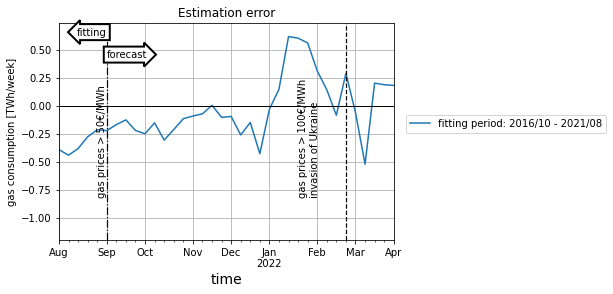

In [42]:
resampled = delta_rlm.resample("1w").sum()

resampled.loc[resampled.index>="2021-08-01"].plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="Estimation error").set_ylabel("gas consumption [TWh/week]")
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))

plt.ylim(resampled.min()[0], resampled.max()[0])


plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
plt.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )

plt.text((pd.to_datetime(high_gas_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.8, "gas prices > 50€/MWh", size=10, rotation=90)
plt.text((pd.to_datetime(invasion_date)-pd.Timedelta(35, "days")).strftime('%Y-%m-%d'), -0.8, "gas prices > 100€/MWh" + "\n" + "invasion of Ukraine", size=10, rotation=90)

plt.ylabel("gas consumption [TWh/week]")
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
plt.xlabel("time",fontsize=14)
plt.axhline(y=0, color='k', lw=1)

fit = plt.text(
    (pd.to_datetime(high_gas_date)-pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 0.7, "fitting", ha="right", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
forecast = plt.text(
    (pd.to_datetime(high_gas_date)+pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 0.5, "forecast", ha="left", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))

ConversionError: Failed to convert value(s) to axis units: '2022-02-24'

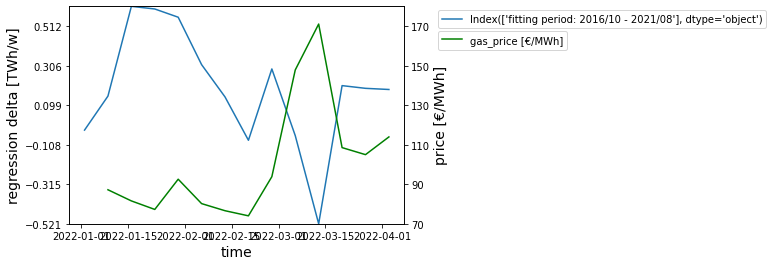

In [43]:
fig,ax = plt.subplots()

column = delta_rlm.columns#[1] 
data = delta_rlm.loc[delta_rlm.index.year==2022, column].resample("w").sum()

ax.plot(data, label=column)

ax.set_ylim(data.min()[0], data.max()[0])
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)

step_size = 20 / 110*((data.max() - data.min())[0]) 
ax.set_yticks(np.arange(data.min()[0], data.max()[0], step_size))

ax.legend(loc=(1.1,0.9))

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["prices"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="green", label="gas_price [€/MWh]")

ax2.set_ylabel("price [€/MWh]", fontsize=14)
ax2.set_ylim(70, 180)
ax2.set_yticks(np.arange(70, 180, 20))

ax2.legend(loc=(1.1,0.8))

plt.axvline(x=invasion_date, color='k', lw=0.7)
#plt.axhline(y=0, color='k', lw=1.2)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

## SLP

In [44]:
#SLP
model_the_slp = smf.ols('slp_the ~ 1 + slp_w2h + C(weekday)', 
                            data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_slp = model_the_slp.fit() 
#results_the_slp.summary()

## Vizualize and analyze predictions

<AxesSubplot:>

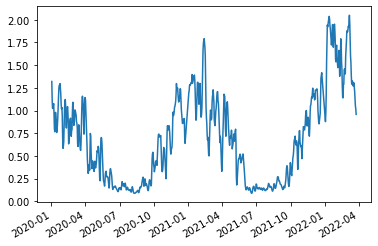

In [45]:
df_x_no_holiday[df_x_no_holiday.index.year>=2020]['slp_w2h'].plot()

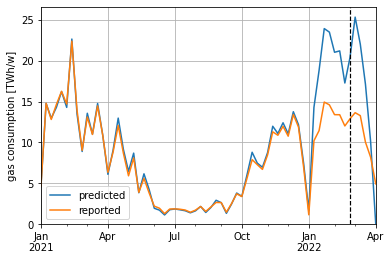

In [46]:
the_slp_prediction = results_the_slp.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction.name = "the_slp_forecast"

the_slp_combined = pd.concat([
    the_slp_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp_the"]
], axis=1, keys=["predicted", "reported"])

the_slp_combined.resample("1w").sum().plot(ylim=0).set_ylabel("gas consumption [TWh/w]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 


plt.show()


In [47]:
delta_the_slp = the_slp_combined.iloc[:,1]-the_slp_combined.iloc[:,0]

Text(0, 0.5, 'regression delta [TWh/w]')

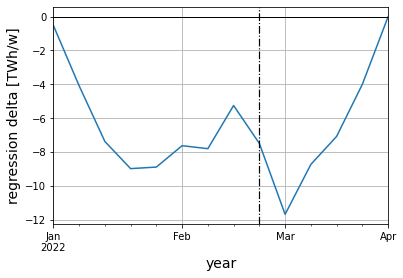

In [48]:
ax = delta_the_slp.loc[delta_the_slp.index.year==2022].resample("w").sum().plot()
ax.axvline(x=invasion_date, color='k', linestyle='-.', lw=1.2 )
ax.axhline(y=0, color='k', lw=1)
plt.grid()
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)


# Further regression variations

In [49]:
high_gas_date = "2021-09-01"
covid_beginning = "2020-02-01"
invasion_date = "2022-02-24"
limiting_date = "2022-03-31"

In [50]:
dummy_1 = pd.concat([
    pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<high_gas_date]),
    pd.Series(1,index=df_x_no_holiday.index[
        (df_x_no_holiday.index>=high_gas_date)&
        (df_x_no_holiday.index<invasion_date)]),
    pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index>invasion_date])
              
              ])

dummy_2 = pd.concat([
    pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<invasion_date]),
    pd.Series(1,index=df_x_no_holiday.index[df_x_no_holiday.index>=invasion_date]),
])

In [51]:
df_x_no_holiday["D1"] = dummy_1
df_x_no_holiday["D2"] = dummy_2

In [52]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

#2020/09-2021/08 (before high gas prices)

model_rdd_only_slp = smf.ols('rlm_the ~ 1 +  D1 + D2 + slp_w2h + C(weekday)', data=df_x_no_holiday)
results_rdd_only_slp = model_rdd_only_slp.fit()

model_rdd_no_econ = smf.ols('rlm_the ~ 1 + D1 + D2+ slp_the + electricity_from_gas + C(weekday)', data=df_x_no_holiday)
results_rdd_no_econ = model_rdd_no_econ.fit() 

 
model_rdd_all = smf.ols('rlm_the ~ 1 + D1 + D2 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday)
results_rdd_all = model_rdd_all.fit() 

Text(0, 0.5, 'estimated reduction [%]')

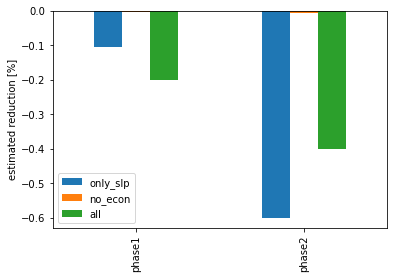

In [53]:
ax = pd.DataFrame(
    data=np.array([
    (results_rdd_all.params.D1, results_rdd_no_econ.params.D1,  results_rdd_only_slp.params.D1), 
    ( results_rdd_only_slp.params.D2, results_rdd_no_econ.params.D2, results_rdd_all.params.D2),
    ]), index=["phase1", "phase2"], columns=["only_slp", "no_econ", "all"]
).plot(kind="bar")
             
ax.set_ylabel("estimated reduction [%]")

In [54]:
#Prices
model_the_prices = smf.ols('rlm_the ~ 1 + prices + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', 
                            data=df_x_no_holiday)
results_the_prices = model_the_prices.fit() 
#results_the_prices.summary()

In [55]:
dummy_coefficients = pd.DataFrame(columns=["dummy_coefficients", "P_value"])

for date in pd.date_range("2020-01-01", "2022-03-01", freq="M"):
    
    dummy = pd.concat([
        pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<date.strftime('%Y-%m-%d')]),
        pd.Series(1,index=df_x_no_holiday.index[df_x_no_holiday.index>=date.strftime('%Y-%m-%d')]),
    ])
    
    df_x_no_holiday["dummy"] = dummy
    
    model = 'rlm_the ~ 1 + dummy + slp_w2h + time + electricity_from_gas + producing_sector + C(weekday)'
    results = smf.ols(model, df_x_no_holiday).fit()
    
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "dummy_coefficients"] = results.params.dummy
    #dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "P_value"] = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0].loc["dummy"]["P>|t|"]

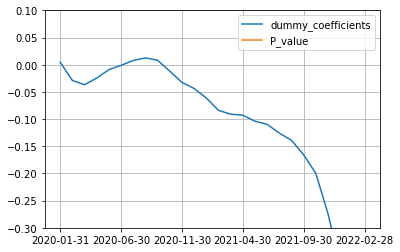

In [56]:
dummy_coefficients.plot(ylim=(-0.3,0.1))
plt.grid()

In [57]:
df_x_no_holiday#.index[0].month==9

,slp_the,rlm_the,bdew,gas_to_electricity,electricity_from_gas,prices,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,...,weekend,christmas_period,holiday,bridgeday,producing_sector,solar,the_sum,D1,D2,dummy
2016-10-01,0.396332,1.262703,NaN,0.567599,0.284400,NaN,0.168296,0.035030,0.005362,0.008936,...,1,0,0,0,101.9,NaN,1.659034,0.0,0,0
2016-10-02,0.511865,1.229047,NaN,0.526653,0.263884,NaN,0.208305,0.051859,0.007938,0.013229,...,1,0,0,0,101.9,NaN,1.740913,0.0,0,0
2016-10-04,0.709381,1.546009,NaN,0.425086,0.212993,NaN,0.275558,0.090982,0.013926,0.023210,...,0,0,0,0,101.9,NaN,2.255391,0.0,0,0
2016-10-05,0.882730,1.629043,NaN,0.476079,0.238543,NaN,0.335879,0.122167,0.018699,0.031165,...,0,0,0,0,101.9,NaN,2.511773,0.0,0,0
2016-10-06,0.951725,1.726405,NaN,0.695275,0.348373,NaN,0.359883,0.136008,0.020817,0.034696,...,0,0,0,0,101.9,NaN,2.678130,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27,1.034631,1.337188,2.023679,0.217971,0.109216,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,106.9,0.175030,2.371819,0.0,1,1
2022-03-28,1.010585,1.595103,2.452018,0.327312,0.164002,102.545,NaN,NaN,NaN,NaN,...,0,0,0,0,106.9,0.193583,2.605687,0.0,1,1
2022-03-29,1.079308,1.714274,2.569742,0.407180,0.204021,108.380,NaN,NaN,NaN,NaN,...,0,0,0,0,106.9,0.143671,2.793583,0.0,1,1
2022-03-30,1.316017,1.812287,3.106882,0.478663,0.239838,118.970,NaN,NaN,NaN,NaN,...,0,0,0,0,106.9,0.102176,3.128304,0.0,1,1


In [58]:
dummy_list = []
for date in pd.date_range('2021-09', '2022-04', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    df_x_no_holiday.loc[df_x_no_holiday.index, dummy_name] = df_x_no_holiday.index.map(
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [59]:
dummy_list

['d2021_9',
 'd2021_10',
 'd2021_11',
 'd2021_12',
 'd2022_1',
 'd2022_2',
 'd2022_3']

In [60]:
pd.Index([function(x) for x in df.index])
df.index.map(lambda x: function(x))
df.index.map(function)

AttributeError: 'OLSResults' object has no attribute 'index'

In [61]:
df = pd.DataFrame(range(1,6))
df['sq'] = df[0].map(lambda x: x**2)
df

,0,sq
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25


In [62]:
df_x_no_holiday#.append().loc[:,f'{date.year}-{date.month}']

,slp_the,rlm_the,bdew,gas_to_electricity,electricity_from_gas,prices,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,...,D1,D2,dummy,d2021_9,d2021_10,d2021_11,d2021_12,d2022_1,d2022_2,d2022_3
2016-10-01,0.396332,1.262703,NaN,0.567599,0.284400,NaN,0.168296,0.035030,0.005362,0.008936,...,0.0,0,0,False,False,False,False,False,False,False
2016-10-02,0.511865,1.229047,NaN,0.526653,0.263884,NaN,0.208305,0.051859,0.007938,0.013229,...,0.0,0,0,False,False,False,False,False,False,False
2016-10-04,0.709381,1.546009,NaN,0.425086,0.212993,NaN,0.275558,0.090982,0.013926,0.023210,...,0.0,0,0,False,False,False,False,False,False,False
2016-10-05,0.882730,1.629043,NaN,0.476079,0.238543,NaN,0.335879,0.122167,0.018699,0.031165,...,0.0,0,0,False,False,False,False,False,False,False
2016-10-06,0.951725,1.726405,NaN,0.695275,0.348373,NaN,0.359883,0.136008,0.020817,0.034696,...,0.0,0,0,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27,1.034631,1.337188,2.023679,0.217971,0.109216,NaN,NaN,NaN,NaN,NaN,...,0.0,1,1,False,False,False,False,False,False,True
2022-03-28,1.010585,1.595103,2.452018,0.327312,0.164002,102.545,NaN,NaN,NaN,NaN,...,0.0,1,1,False,False,False,False,False,False,True
2022-03-29,1.079308,1.714274,2.569742,0.407180,0.204021,108.380,NaN,NaN,NaN,NaN,...,0.0,1,1,False,False,False,False,False,False,True
2022-03-30,1.316017,1.812287,3.106882,0.478663,0.239838,118.970,NaN,NaN,NaN,NaN,...,0.0,1,1,False,False,False,False,False,False,True


In [63]:
df_x_no_holiday['Sep21'].iloc[-230:]

KeyError: 'Sep21'

<AxesSubplot:>

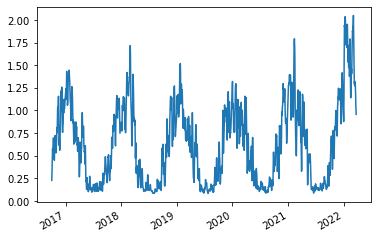

In [64]:
df_x_no_holiday['slp_w2h'].plot()

In [157]:
model = 'rlm_the ~ 1 + slp_w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit()

In [158]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rlm_the   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1126.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:56:52   Log-Likelihood:                 1843.6
No. Observations:                1841   AIC:                            -3633.
Df Residuals:                    1814   BIC:                            -3484.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.3258      0.016     82.474      0.000       1.294       1.357
C(weekday)[T.Monday]        0.0572      0.008      7.335      0.000       0.042       0.073
C(weekday)[T.Saturday]     -0.2365      0.008    -30.768      0.000      -0.252      -0.221
C(weekday)[T.Sunday]       -0.2376      0.008    -30.849      0.000      -0.253      -0.223
C(weekday)[T.Thursday]      0.0637      0.008      8.034      0.000       0.048       0.079
C(weekday)[T.Tuesday]       0.0723      0.008      9.299      0.000       0.057       0.088
C(weekday)[T.Wednesday]     0.0718      0.008      9.228      0.000       0.057       0.087
C(month)[T.2]              -0.0264      0.011     -2.433      0.015      -0.048      -0.005
C(month)[T.3]              -0.1190      0.011    -10.724      0.000      -0.141      -0.097
C(month)[T.4]              -0.1895      0.013    -15.069      0.000      -0.214      -0.165
C(month)[T.5]              -0.1917      0.014    -13.811      0.000      -0.219      -0.164
C(month)[T.6]              -0.1307      0.016     -8.350      0.000      -0.161      -0.100
C(month)[T.7]              -0.1294      0.016     -8.307      0.000      -0.160      -0.099
C(month)[T.8]              -0.1738      0.016    -11.127      0.000      -0.204      -0.143
C(month)[T.9]              -0.1068      0.015     -7.124      0.000      -0.136      -0.077
C(month)[T.10]             -0.0411      0.013     -3.141      0.002      -0.067      -0.015
C(month)[T.11]              0.0050      0.011      0.447      0.655      -0.017       0.027
C(month)[T.12]             -0.0024      0.012     -0.201      0.840      -0.025       0.021
d2021_9[T.True]            -0.1037      0.019     -5.391      0.000      -0.141      -0.066
d2021_10[T.True]           -0.1997      0.019    -10.597      0.000      -0.237      -0.163
d2021_11[T.True]           -0.0870      0.019     -4.554      0.000      -0.125      -0.050
d2021_12[T.True]           -0.0660      0.023     -2.896      0.004      -0.111      -0.021
d2022_1[T.True]            -0.5326      0.021    -25.592      0.000      -0.573      -0.492
d2022_2[T.True]            -0.5543      0.020    -28.020      0.000      -0.593      -0.515
d2022_3[T.True]            -0.5279      0.021    -24.986      0.000      -0.569      -0.486
slp_w2h                     0.7007      0.011     61.028      0.000       0.678       0.723
time                     1.443e-05   4.34e-06      3.326      0.001    5.92e-06    2.29e-05
==============================================================================
Omnibus:                      168.058   Durbin-Watson:                   0.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              555.188
Skew:                          -0.434   Prob(JB):                    2.77e-121
Kurtosi

In [159]:
extracted_results = pd.concat(
    [results.params, results.HC0_se], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

,coef,se,low,high
d2021_9,-0.103725,0.012305,-0.128334,-0.079116
d2021_10,-0.199683,0.011827,-0.223336,-0.176029
d2021_11,-0.087039,0.018708,-0.124455,-0.049623
d2021_12,-0.066023,0.033057,-0.132138,0.000092
d2022_1,-0.532571,0.035926,-0.604424,-0.460718
d2022_2,-0.554258,0.019216,-0.592690,-0.515825
d2022_3,-0.527939,0.039002,-0.605944,-0.449935


(-0.7, 0.05)

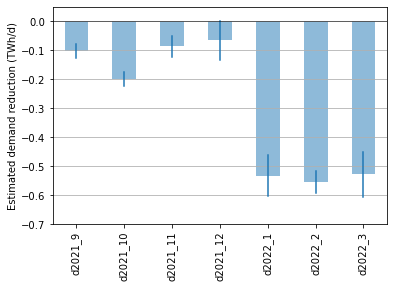

In [192]:
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.ylim(-0.7, 0.05)

In [87]:
mean_list = df_x_no_holiday.loc[df_x_no_holiday.index > pd.Timestamp('2021-09-01'), 'rlm_the'].resample('1m').mean().values
normalized_results = pd.concat([
    extracted_results[col]/(mean_list - extracted_results[col])*100
    for col in extracted_results.columns
], axis=1, keys= extracted_results.columns)

(-30.0, 2.0)

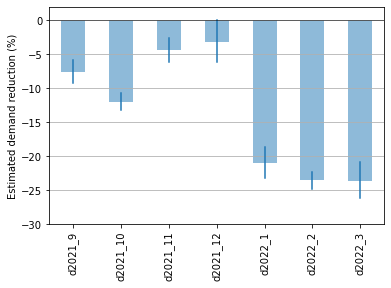

In [88]:
ax = normalized_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [normalized_results.loc[d, 'low'], normalized_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.ylim(-30, 2)
#plt.xticklabels()

In [194]:
mean_list

array([1.26583362, 1.46634522, 1.88709216, 2.02070982, 2.0071882 ,
       1.80043592, 1.70988288])

In [89]:
normalized_results

,coef,se,low,high
d2021_9,-7.573629,0.981592,-9.205087,-5.882467
d2021_10,-11.985553,0.813104,-13.217650,-10.717968
d2021_11,-4.408983,1.001299,-6.187045,-2.562220
d2021_12,-3.163953,1.663138,-6.137826,0.004531
d2022_1,-20.969360,1.822509,-23.143717,-18.668392
d2022_2,-23.538425,1.078824,-24.766361,-22.269741
d2022_3,-23.591651,2.334235,-26.165333,-20.832066


In [90]:
results.resid.iloc[-85:-75]#.plot()

2021-12-17    0.087860
2021-12-18    0.032082
2021-12-19   -0.065890
2021-12-20    0.088605
2021-12-21    0.028521
2021-12-23   -0.518855
2022-01-02    0.094082
2022-01-03    0.544347
2022-01-04    0.084820
2022-01-05   -0.115399
dtype: float64

In [95]:
#include log of rlm_the to get (approx.) percent changes in dependent variable

df_x_no_holiday['log_rlm_the'] = np.log(df_x_no_holiday['rlm_the'])

In [182]:
model = 'log_rlm_the ~ 1 + slp_w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit()

In [183]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_rlm_the   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1123.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:06:53   Log-Likelihood:                 2731.8
No. Observations:                1841   AIC:                            -5410.
Df Residuals:                    1814   BIC:                            -5261.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.3093      0.010     31.170      0.000       0.290       0.329
C(weekday)[T.Monday]        0.0337      0.005      7.009      0.000       0.024       0.043
C(weekday)[T.Saturday]     -0.1594      0.005    -33.591      0.000      -0.169      -0.150
C(weekday)[T.Sunday]       -0.1607      0.005    -33.803      0.000      -0.170      -0.151
C(weekday)[T.Thursday]      0.0397      0.005      8.110      0.000       0.030       0.049
C(weekday)[T.Tuesday]       0.0436      0.005      9.080      0.000       0.034       0.053
C(weekday)[T.Wednesday]     0.0443      0.005      9.225      0.000       0.035       0.054
C(month)[T.2]              -0.0127      0.007     -1.897      0.058      -0.026       0.000
C(month)[T.3]              -0.0562      0.007     -8.202      0.000      -0.070      -0.043
C(month)[T.4]              -0.1127      0.008    -14.520      0.000      -0.128      -0.098
C(month)[T.5]              -0.1309      0.009    -15.281      0.000      -0.148      -0.114
C(month)[T.6]              -0.1145      0.010    -11.847      0.000      -0.133      -0.096
C(month)[T.7]              -0.1135      0.010    -11.810      0.000      -0.132      -0.095
C(month)[T.8]              -0.1472      0.010    -15.268      0.000      -0.166      -0.128
C(month)[T.9]              -0.0795      0.009     -8.583      0.000      -0.098      -0.061
C(month)[T.10]             -0.0173      0.008     -2.144      0.032      -0.033      -0.001
C(month)[T.11]              0.0121      0.007      1.742      0.082      -0.002       0.026
C(month)[T.12]              0.0041      0.007      0.572      0.567      -0.010       0.018
d2021_9[T.True]            -0.0827      0.012     -6.963      0.000      -0.106      -0.059
d2021_10[T.True]           -0.1249      0.012    -10.741      0.000      -0.148      -0.102
d2021_11[T.True]           -0.0503      0.012     -4.267      0.000      -0.073      -0.027
d2021_12[T.True]           -0.0377      0.014     -2.678      0.007      -0.065      -0.010
d2022_1[T.True]            -0.2959      0.013    -23.035      0.000      -0.321      -0.271
d2022_2[T.True]            -0.2982      0.012    -24.420      0.000      -0.322      -0.274
d2022_3[T.True]            -0.2984      0.013    -22.883      0.000      -0.324      -0.273
slp_w2h                     0.3896      0.007     54.975      0.000       0.376       0.404
time                     1.084e-05   2.68e-06      4.047      0.000    5.59e-06    1.61e-05
==============================================================================
Omnibus:                      112.349   Durbin-Watson:                   0.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.356
Skew:                          -0.434   Prob(JB):                     1.27e-46
Kurtosi

In [184]:
extracted_results = pd.concat(
    [results.params*100, results.HC0_se*100], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

,coef,se,low,high
d2021_9,-8.268939,0.840901,-9.950742,-6.587136
d2021_10,-12.494036,0.816243,-14.126522,-10.861550
d2021_11,-5.033900,0.994279,-7.022459,-3.045342
d2021_12,-3.767983,1.785623,-7.339229,-0.196738
d2022_1,-29.590511,1.951405,-33.493321,-25.687702
d2022_2,-29.817657,1.011240,-31.840136,-27.795178
d2022_3,-29.844734,2.153224,-34.151183,-25.538285


(-40.0, 2.0)

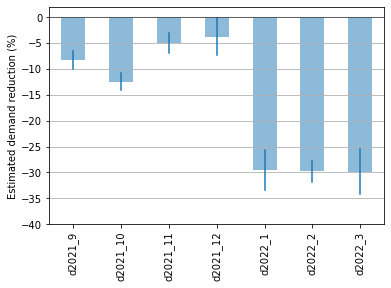

In [186]:
# percent reduction using log transformation of rlm_the

ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.ylim(-40, 2)

In [187]:
#calculate normalized results by division by mean of rlm_the across entire sample (without log transformation, using original rlm_the)

model = 'rlm_the ~ 1 + slp_w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit()

In [188]:
extracted_results = pd.concat(
    [results.params, results.HC0_se], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

,coef,se,low,high
d2021_9,-0.103725,0.012305,-0.128334,-0.079116
d2021_10,-0.199683,0.011827,-0.223336,-0.176029
d2021_11,-0.087039,0.018708,-0.124455,-0.049623
d2021_12,-0.066023,0.033057,-0.132138,0.000092
d2022_1,-0.532571,0.035926,-0.604424,-0.460718
d2022_2,-0.554258,0.019216,-0.592690,-0.515825
d2022_3,-0.527939,0.039002,-0.605944,-0.449935


In [189]:
mean_rlm_the = df_x_no_holiday['rlm_the'].mean()

normalized_results = extracted_results/mean_rlm_the*100

In [190]:
normalized_results

,coef,se,low,high
d2021_9,-6.392661,0.758337,-7.909335,-4.875987
d2021_10,-12.306577,0.728891,-13.764359,-10.848796
d2021_11,-5.364280,1.152994,-7.670267,-3.058292
d2021_12,-4.069057,2.037350,-8.143757,0.005643
d2022_1,-32.822731,2.214169,-37.251069,-28.394392
d2022_2,-34.159284,1.184309,-36.527901,-31.790667
d2022_3,-32.537248,2.403737,-37.344722,-27.729773


(-40.0, 2.0)

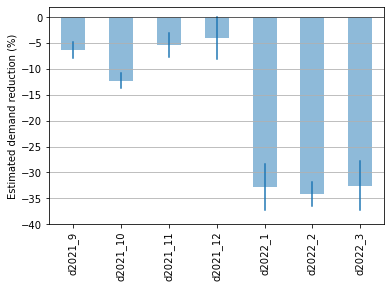

In [191]:
ax = normalized_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [normalized_results.loc[d, 'low'], normalized_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.ylim(-40, 2)
#plt.xticklabels()